In [2]:
import os
os.environ["WANDB_API_KEY"] = "dcf9600e0485401cbb0ddbb0f7be1c70f96b32ef"
os.environ["WANDB_MODE"] = "disabled"
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipdb
import wandb
from sigma_layer import SigmaLinear, SigmaConv, SigmaView
from utils import get_dataset, gradient_centralization, normalize_along_axis, get_activation_function, compute_SCL_loss
import datetime

In [3]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# Training scheme group
method_parser = parser.add_argument_group("Method")
method_parser.add_argument('--method', type=str, default='SIGMA', choices=['SIGMA', 'BP', 'FA'])
method_parser.add_argument('--actfunc', type=str, default='elu', choices=['tanh', 'elu', 'relu'])
method_parser.add_argument('--conv_dim', type=int, default=32, choices=[32, 64])
# Dataset group
dataset_parser = parser.add_argument_group('Dataset')
dataset_parser.add_argument('--dataset', type=str, default='MNIST', choices=['MNIST', 'CIFAR10'])
dataset_parser.add_argument('--batchsize', type=int, default=64)
dataset_parser.add_argument('--splitratio', type=float, default=0.2)
# Training group # LR, optimizer, weight_decay, momentum
training_parser = parser.add_argument_group('Training')
training_parser.add_argument('--epochs', type=int, default=100)
training_parser.add_argument('--lr', type=float, default=1)
training_parser.add_argument('--optimizer', type=str, default='SGD', choices=['RMSprop', 'Adam', 'SGD'])
# Seed group
seed_parser = parser.add_argument_group('Seed')
seed_parser.add_argument('--seed', type=int, default=2023)
args, _ = parser.parse_known_args()

# Set run_name
run_name = f"{args.dataset}_{args.method}_conv{args.conv_dim}-act{args.actfunc}_{args.optimizer}_{args.lr}_{args.seed}"
time_stamp = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")

# Set wandb
wandb.init(
    project="opt-sigma",
    name=run_name,
    # track hyperparameters and run metadata
    config={
    "algorithm": args.method,
    "architecture": "SimpleCNN",
    "dataset": args.dataset,
    "epochs": args.epochs,
    "lr": args.lr,
    "optimizer": args.optimizer,
    "seed": args.seed,
    "conv_dim": args.conv_dim,
    "actfunc": args.actfunc,
    }
)

print(f"Run name: {run_name}")

# Set seed
torch.manual_seed(args.seed), np.random.seed(args.seed)

# Set device
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

# Get dataset
train_loader, val_loader, test_loader = get_dataset(args)

class SigmaModel_SimpleCNN(nn.Module):
    def __init__(self, args):
        super(SigmaModel_SimpleCNN, self).__init__()
        self.LN1 = torch.nn.LayerNorm((1,28,28), elementwise_affine=False) 
        self.LN2 = torch.nn.LayerNorm((args.conv_dim,14,14), elementwise_affine=False) 
        self.conv1 = SigmaConv(1, args.conv_dim, 3, args)
        self.conv2 = SigmaConv(args.conv_dim, 64, 3, args)
        self.view1 = SigmaView((64, 7, 7), 64 * 7 * 7)
        self.fc1 = SigmaLinear(64 * 7 * 7, 128, args)
        self.fc2 = SigmaLinear(128, 10, args)
                
        self.forward_params = list()
        self.backward_params = list()
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2]:
            forward_params, backward_params = layer.get_parameters()
            self.forward_params += forward_params
            self.backward_params += backward_params

    def forward(self, x, detach_grad=False, return_activations=True):   
        # x = self.LN1(x)
        a1 = self.conv1(x, detach_grad)
        a2 = self.conv2(a1, detach_grad)
        a2 = self.view1(a2, detach_grad)
        a3 = self.fc1(a2, detach_grad)
        a4 = self.fc2(a3, detach_grad)
        return [a1, a2, a3, a4]
        
    def reverse(self, target, detach_grad=True, return_activations=True):
        if target.shape == torch.Size([10]): 
            target = F.one_hot(target, num_classes=10).float().to(target.device)
        b3 = self.fc2.reverse(target, detach_grad)
        b2 = self.fc1.reverse(b3, detach_grad)
        b2 = self.view1.reverse(b2, detach_grad)
        b1 = self.conv2.reverse(b2, detach_grad)
        return [b1, b2, b3, target]


class SigmaLoss(nn.Module):
    def __init__(self, args):
        super(SigmaLoss, self).__init__()
        self.args = args
        self.final_criteria = nn.CrossEntropyLoss()
        self.local_criteria = compute_SCL_loss
        self.method = args.method
        
    def forward(self, activations, signals, target, method="final"):
        """
        Activations and signals are list of activations
        target is a onehot representation of target sigals
        """
        if method == "local":
            loss = list()
            for act, sig in zip(activations[:-1], signals[:-1]):
                loss += [self.local_criteria(act, sig, target)]
            loss += [self.final_criteria(activations[-1], target)]
            return sum(loss), loss[-1].item()
        elif method == "final":
            loss = self.final_criteria(activations[-1], target)
            return loss, loss.item()
        
model = SigmaModel_SimpleCNN(args)
model.to(device)
if args.optimizer == "SGD": 
    forward_optimizer = optim.SGD(model.forward_params, lr=args.lr)
    backward_optimizer = optim.SGD(model.forward_params, lr=args.lr)
elif args.optimizer == "RMSprop": forward_optimizer = optim.RMSprop(model.forward_params, lr=args.lr, weight_decay=0)
elif args.optimizer == "Adam": forward_optimizer = optim.Adam(model.forward_params, lr=args.lr)
criteria = SigmaLoss(args)
    
with torch.no_grad():
    signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), return_activations=True)
    
best_val_loss = float('inf')

print("No LN1")
for epoch in tqdm(range(args.epochs)):
    
    train_loss, train_counter = 0, 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        if args.method == "SIGMA":
            activations = model(data.to(device), detach_grad=True)
            signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), detach_grad=True)
            loss, loss_item = criteria(activations, signals, target.to(device), method="local")
        elif args.method == "BP":
            activations = model(data.to(device), detach_grad=False)
            loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), backward_optimizer.zero_grad(), loss.backward()
        gradient_centralization(model), forward_optimizer.step(), backward_optimizer.step()
        train_loss += loss_item * len(data)
        train_counter += len(data)

    wandb.log({'train_loss': train_loss / train_counter}, step=epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        activations = model(data.to(device), detach_grad=True)
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), loss.backward(), forward_optimizer.step()

    # Validation
    val_correct, val_loss, val_counter = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            val_counter += len(data)
            if args.method == "SIGMA":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="local")
                
            elif args.method == "BP":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="final")
            prediction = activations[-1].detach()
            _, predicted = torch.max(prediction, 1)
            val_correct += (predicted == target.to(device)).sum().item()
            val_loss += loss_item * len(data)

    wandb.log({'val_loss': val_loss / val_counter, 
               'val_acc': val_correct / val_counter, 
               }, step=epoch)
    
    print(f"""Epoch {epoch} | train loss {train_loss / train_counter:.4f} | val loss {val_loss / val_counter:.4f} | val acc {100 * val_correct / val_counter:.4f}""")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), f'./saved_models/{run_name}-{time_stamp}.pt')
        

# Eval on Test Set by loading the best model 
model.load_state_dict(torch.load(f'./saved_models/{run_name}-{time_stamp}.pt'))
model.eval()
correct, total = 0, 0
test_loss, test_counter = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data.to(device), detach_grad=False)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == target.to(device)).sum().item()
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        test_loss += loss_item * len(data)
        test_counter += len(data)

wandb.log({'test_loss': test_loss / test_counter,
           'test_acc': 100 * correct / test_counter})

print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / test_counter:.4f}%')

Run name: MNIST_SIGMA_conv32-actelu_SGD_1_2023
No LN1


  1%|▍                                          | 1/100 [00:09<14:57,  9.06s/it]

Epoch 0 | train loss 2.0463 | val loss 0.9540 | val acc 66.0833


  2%|▊                                          | 2/100 [00:18<15:05,  9.24s/it]

Epoch 1 | train loss 0.7824 | val loss 0.1929 | val acc 94.4000


  3%|█▎                                         | 3/100 [00:27<15:00,  9.28s/it]

Epoch 2 | train loss 0.1708 | val loss 0.1329 | val acc 96.0333


  4%|█▋                                         | 4/100 [00:36<14:42,  9.19s/it]

Epoch 3 | train loss 0.1413 | val loss 0.1089 | val acc 96.8167


  5%|██▏                                        | 5/100 [00:45<14:29,  9.15s/it]

Epoch 4 | train loss 0.1127 | val loss 0.1004 | val acc 97.0583


  6%|██▌                                        | 6/100 [00:54<14:16,  9.11s/it]

Epoch 5 | train loss 0.1063 | val loss 0.0938 | val acc 97.0417


  7%|███                                        | 7/100 [01:04<14:08,  9.12s/it]

Epoch 6 | train loss 0.0878 | val loss 0.0878 | val acc 97.3250


  8%|███▍                                       | 8/100 [01:13<13:58,  9.12s/it]

Epoch 7 | train loss 0.0837 | val loss 0.0867 | val acc 97.3667


  9%|███▊                                       | 9/100 [01:22<13:49,  9.12s/it]

Epoch 8 | train loss 0.0725 | val loss 0.0810 | val acc 97.4833


 10%|████▏                                     | 10/100 [01:32<13:58,  9.31s/it]

Epoch 9 | train loss 0.0753 | val loss 0.0801 | val acc 97.5000


 11%|████▌                                     | 11/100 [01:41<14:00,  9.44s/it]

Epoch 10 | train loss 0.0752 | val loss 0.0765 | val acc 97.6250


 12%|█████                                     | 12/100 [01:51<13:52,  9.46s/it]

Epoch 11 | train loss 0.0781 | val loss 0.0738 | val acc 97.6583


 13%|█████▍                                    | 13/100 [02:00<13:42,  9.45s/it]

Epoch 12 | train loss 0.0670 | val loss 0.0740 | val acc 97.6583


 14%|█████▉                                    | 14/100 [02:10<13:32,  9.45s/it]

Epoch 13 | train loss 0.0689 | val loss 0.0712 | val acc 97.6667


 15%|██████▎                                   | 15/100 [02:19<13:22,  9.44s/it]

Epoch 14 | train loss 0.0574 | val loss 0.0690 | val acc 97.8583


 16%|██████▋                                   | 16/100 [02:29<13:14,  9.46s/it]

Epoch 15 | train loss 0.0724 | val loss 0.0674 | val acc 97.9167


 17%|███████▏                                  | 17/100 [02:38<13:04,  9.45s/it]

Epoch 16 | train loss 0.0660 | val loss 0.0659 | val acc 97.8750


 18%|███████▌                                  | 18/100 [02:47<12:49,  9.38s/it]

Epoch 17 | train loss 0.0718 | val loss 0.0634 | val acc 98.0083


 19%|███████▉                                  | 19/100 [02:57<12:37,  9.35s/it]

Epoch 18 | train loss 0.0631 | val loss 0.0633 | val acc 98.0833


 20%|████████▍                                 | 20/100 [03:06<12:31,  9.40s/it]

Epoch 19 | train loss 0.0695 | val loss 0.0629 | val acc 98.0250


 21%|████████▊                                 | 21/100 [03:15<12:20,  9.38s/it]

Epoch 20 | train loss 0.0599 | val loss 0.0622 | val acc 97.9917


 22%|█████████▏                                | 22/100 [03:24<12:04,  9.29s/it]

Epoch 21 | train loss 0.0627 | val loss 0.0594 | val acc 98.0417


 23%|█████████▋                                | 23/100 [03:34<11:58,  9.33s/it]

Epoch 22 | train loss 0.0510 | val loss 0.0603 | val acc 98.0833


 24%|██████████                                | 24/100 [03:44<11:58,  9.45s/it]

Epoch 23 | train loss 0.0493 | val loss 0.0607 | val acc 98.1417


 25%|██████████▌                               | 25/100 [03:53<11:48,  9.45s/it]

Epoch 24 | train loss 0.0533 | val loss 0.0608 | val acc 98.0333


 26%|██████████▉                               | 26/100 [04:02<11:31,  9.35s/it]

Epoch 25 | train loss 0.0523 | val loss 0.0577 | val acc 98.2333


 27%|███████████▎                              | 27/100 [04:12<11:23,  9.37s/it]

Epoch 26 | train loss 0.0623 | val loss 0.0587 | val acc 98.1417


 28%|███████████▊                              | 28/100 [04:21<11:11,  9.33s/it]

Epoch 27 | train loss 0.0450 | val loss 0.0589 | val acc 98.1250


 29%|████████████▏                             | 29/100 [04:30<11:03,  9.34s/it]

Epoch 28 | train loss 0.0490 | val loss 0.0571 | val acc 98.2750


 30%|████████████▌                             | 30/100 [04:40<10:57,  9.40s/it]

Epoch 29 | train loss 0.0575 | val loss 0.0580 | val acc 98.1833


 31%|█████████████                             | 31/100 [04:49<10:42,  9.32s/it]

Epoch 30 | train loss 0.0510 | val loss 0.0559 | val acc 98.2083


 32%|█████████████▍                            | 32/100 [04:58<10:36,  9.36s/it]

Epoch 31 | train loss 0.0545 | val loss 0.0575 | val acc 98.1750


 33%|█████████████▊                            | 33/100 [05:07<10:20,  9.26s/it]

Epoch 32 | train loss 0.0518 | val loss 0.0534 | val acc 98.2750


 34%|██████████████▎                           | 34/100 [05:16<10:09,  9.23s/it]

Epoch 33 | train loss 0.0487 | val loss 0.0556 | val acc 98.1833


 35%|██████████████▋                           | 35/100 [05:26<10:04,  9.30s/it]

Epoch 34 | train loss 0.0554 | val loss 0.0541 | val acc 98.2333


 36%|███████████████                           | 36/100 [05:35<09:58,  9.35s/it]

Epoch 35 | train loss 0.0467 | val loss 0.0536 | val acc 98.2667


 37%|███████████████▌                          | 37/100 [05:45<09:52,  9.40s/it]

Epoch 36 | train loss 0.0438 | val loss 0.0522 | val acc 98.3667


 38%|███████████████▉                          | 38/100 [05:55<09:47,  9.48s/it]

Epoch 37 | train loss 0.0405 | val loss 0.0545 | val acc 98.2083


 39%|████████████████▍                         | 39/100 [06:04<09:40,  9.52s/it]

Epoch 38 | train loss 0.0479 | val loss 0.0522 | val acc 98.3250


 40%|████████████████▊                         | 40/100 [06:14<09:28,  9.47s/it]

Epoch 39 | train loss 0.0456 | val loss 0.0528 | val acc 98.2833


 41%|█████████████████▏                        | 41/100 [06:23<09:13,  9.39s/it]

Epoch 40 | train loss 0.0502 | val loss 0.0532 | val acc 98.2417


 42%|█████████████████▋                        | 42/100 [06:32<09:01,  9.33s/it]

Epoch 41 | train loss 0.0508 | val loss 0.0529 | val acc 98.3000


 43%|██████████████████                        | 43/100 [06:41<08:44,  9.19s/it]

Epoch 42 | train loss 0.0395 | val loss 0.0521 | val acc 98.3083


 44%|██████████████████▍                       | 44/100 [06:50<08:31,  9.13s/it]

Epoch 43 | train loss 0.0514 | val loss 0.0540 | val acc 98.2417


 45%|██████████████████▉                       | 45/100 [06:59<08:18,  9.07s/it]

Epoch 44 | train loss 0.0456 | val loss 0.0532 | val acc 98.3333


 46%|███████████████████▎                      | 46/100 [07:08<08:06,  9.01s/it]

Epoch 45 | train loss 0.0492 | val loss 0.0535 | val acc 98.3250


 47%|███████████████████▋                      | 47/100 [07:16<07:55,  8.97s/it]

Epoch 46 | train loss 0.0319 | val loss 0.0547 | val acc 98.2750


 48%|████████████████████▏                     | 48/100 [07:25<07:47,  9.00s/it]

Epoch 47 | train loss 0.0434 | val loss 0.0534 | val acc 98.3583


 49%|████████████████████▌                     | 49/100 [07:35<07:41,  9.06s/it]

Epoch 48 | train loss 0.0425 | val loss 0.0553 | val acc 98.3250


 50%|█████████████████████                     | 50/100 [07:44<07:38,  9.16s/it]

Epoch 49 | train loss 0.0438 | val loss 0.0545 | val acc 98.2583


 51%|█████████████████████▍                    | 51/100 [07:53<07:28,  9.16s/it]

Epoch 50 | train loss 0.0412 | val loss 0.0526 | val acc 98.3667


 52%|█████████████████████▊                    | 52/100 [08:03<07:30,  9.38s/it]

Epoch 51 | train loss 0.0396 | val loss 0.0538 | val acc 98.2250


 53%|██████████████████████▎                   | 53/100 [08:13<07:23,  9.43s/it]

Epoch 52 | train loss 0.0418 | val loss 0.0523 | val acc 98.3417


 54%|██████████████████████▋                   | 54/100 [08:22<07:11,  9.39s/it]

Epoch 53 | train loss 0.0442 | val loss 0.0525 | val acc 98.3417


 55%|███████████████████████                   | 55/100 [08:31<06:57,  9.28s/it]

Epoch 54 | train loss 0.0435 | val loss 0.0530 | val acc 98.3167


 56%|███████████████████████▌                  | 56/100 [08:40<06:44,  9.20s/it]

Epoch 55 | train loss 0.0417 | val loss 0.0534 | val acc 98.3000


 57%|███████████████████████▉                  | 57/100 [08:49<06:37,  9.24s/it]

Epoch 56 | train loss 0.0433 | val loss 0.0515 | val acc 98.4583


 58%|████████████████████████▎                 | 58/100 [08:59<06:32,  9.35s/it]

Epoch 57 | train loss 0.0425 | val loss 0.0505 | val acc 98.3167


 59%|████████████████████████▊                 | 59/100 [09:08<06:23,  9.36s/it]

Epoch 58 | train loss 0.0325 | val loss 0.0525 | val acc 98.3583


 60%|█████████████████████████▏                | 60/100 [09:17<06:09,  9.23s/it]

Epoch 59 | train loss 0.0396 | val loss 0.0503 | val acc 98.4083


 61%|█████████████████████████▌                | 61/100 [09:27<06:00,  9.24s/it]

Epoch 60 | train loss 0.0440 | val loss 0.0501 | val acc 98.4750


 62%|██████████████████████████                | 62/100 [09:36<05:50,  9.22s/it]

Epoch 61 | train loss 0.0401 | val loss 0.0537 | val acc 98.2917


 63%|██████████████████████████▍               | 63/100 [09:45<05:38,  9.14s/it]

Epoch 62 | train loss 0.0354 | val loss 0.0517 | val acc 98.4083


 64%|██████████████████████████▉               | 64/100 [09:55<05:37,  9.38s/it]

Epoch 63 | train loss 0.0367 | val loss 0.0527 | val acc 98.4000


 65%|███████████████████████████▎              | 65/100 [10:04<05:30,  9.43s/it]

Epoch 64 | train loss 0.0411 | val loss 0.0519 | val acc 98.4583


 66%|███████████████████████████▋              | 66/100 [10:14<05:22,  9.49s/it]

Epoch 65 | train loss 0.0380 | val loss 0.0526 | val acc 98.4333


 67%|████████████████████████████▏             | 67/100 [10:23<05:11,  9.44s/it]

Epoch 66 | train loss 0.0338 | val loss 0.0518 | val acc 98.3750


 68%|████████████████████████████▌             | 68/100 [10:32<04:58,  9.32s/it]

Epoch 67 | train loss 0.0404 | val loss 0.0527 | val acc 98.3583


 69%|████████████████████████████▉             | 69/100 [10:41<04:44,  9.18s/it]

Epoch 68 | train loss 0.0409 | val loss 0.0517 | val acc 98.3583


 70%|█████████████████████████████▍            | 70/100 [10:50<04:34,  9.15s/it]

Epoch 69 | train loss 0.0379 | val loss 0.0498 | val acc 98.5583


 71%|█████████████████████████████▊            | 71/100 [10:59<04:25,  9.14s/it]

Epoch 70 | train loss 0.0383 | val loss 0.0508 | val acc 98.3667


 72%|██████████████████████████████▏           | 72/100 [11:09<04:20,  9.32s/it]

Epoch 71 | train loss 0.0328 | val loss 0.0522 | val acc 98.4333


 73%|██████████████████████████████▋           | 73/100 [11:18<04:09,  9.24s/it]

Epoch 72 | train loss 0.0353 | val loss 0.0496 | val acc 98.5167


 74%|███████████████████████████████           | 74/100 [11:28<04:04,  9.39s/it]

Epoch 73 | train loss 0.0422 | val loss 0.0506 | val acc 98.5667


 75%|███████████████████████████████▌          | 75/100 [11:37<03:53,  9.35s/it]

Epoch 74 | train loss 0.0396 | val loss 0.0521 | val acc 98.4167


 76%|███████████████████████████████▉          | 76/100 [11:46<03:43,  9.33s/it]

Epoch 75 | train loss 0.0323 | val loss 0.0507 | val acc 98.4750


 77%|████████████████████████████████▎         | 77/100 [11:56<03:34,  9.34s/it]

Epoch 76 | train loss 0.0352 | val loss 0.0499 | val acc 98.4500


 78%|████████████████████████████████▊         | 78/100 [12:05<03:22,  9.22s/it]

Epoch 77 | train loss 0.0325 | val loss 0.0510 | val acc 98.3917


 79%|█████████████████████████████████▏        | 79/100 [12:14<03:12,  9.19s/it]

Epoch 78 | train loss 0.0359 | val loss 0.0499 | val acc 98.4500


 80%|█████████████████████████████████▌        | 80/100 [12:23<03:03,  9.17s/it]

Epoch 79 | train loss 0.0347 | val loss 0.0507 | val acc 98.4750


 81%|██████████████████████████████████        | 81/100 [12:32<02:54,  9.19s/it]

Epoch 80 | train loss 0.0366 | val loss 0.0483 | val acc 98.4750


 82%|██████████████████████████████████▍       | 82/100 [12:41<02:44,  9.16s/it]

Epoch 81 | train loss 0.0421 | val loss 0.0493 | val acc 98.3583


 83%|██████████████████████████████████▊       | 83/100 [12:50<02:34,  9.09s/it]

Epoch 82 | train loss 0.0361 | val loss 0.0496 | val acc 98.5417


 84%|███████████████████████████████████▎      | 84/100 [12:59<02:24,  9.01s/it]

Epoch 83 | train loss 0.0357 | val loss 0.0496 | val acc 98.4667


 85%|███████████████████████████████████▋      | 85/100 [13:08<02:14,  8.96s/it]

Epoch 84 | train loss 0.0338 | val loss 0.0500 | val acc 98.4750


 86%|████████████████████████████████████      | 86/100 [13:17<02:05,  8.99s/it]

Epoch 85 | train loss 0.0389 | val loss 0.0480 | val acc 98.5000


 87%|████████████████████████████████████▌     | 87/100 [13:26<01:58,  9.08s/it]

Epoch 86 | train loss 0.0355 | val loss 0.0495 | val acc 98.5750


 88%|████████████████████████████████████▉     | 88/100 [13:36<01:50,  9.18s/it]

Epoch 87 | train loss 0.0384 | val loss 0.0478 | val acc 98.4750


 89%|█████████████████████████████████████▍    | 89/100 [13:45<01:42,  9.35s/it]

Epoch 88 | train loss 0.0309 | val loss 0.0503 | val acc 98.4583


 90%|█████████████████████████████████████▊    | 90/100 [13:54<01:31,  9.20s/it]

Epoch 89 | train loss 0.0392 | val loss 0.0482 | val acc 98.5417


 91%|██████████████████████████████████████▏   | 91/100 [14:03<01:21,  9.10s/it]

Epoch 90 | train loss 0.0336 | val loss 0.0481 | val acc 98.5000


 92%|██████████████████████████████████████▋   | 92/100 [14:12<01:12,  9.08s/it]

Epoch 91 | train loss 0.0394 | val loss 0.0479 | val acc 98.4833


 93%|███████████████████████████████████████   | 93/100 [14:21<01:03,  9.09s/it]

Epoch 92 | train loss 0.0376 | val loss 0.0481 | val acc 98.5250


 94%|███████████████████████████████████████▍  | 94/100 [14:30<00:54,  9.03s/it]

Epoch 93 | train loss 0.0368 | val loss 0.0493 | val acc 98.4417


 95%|███████████████████████████████████████▉  | 95/100 [14:39<00:44,  9.00s/it]

Epoch 94 | train loss 0.0339 | val loss 0.0488 | val acc 98.4417


 96%|████████████████████████████████████████▎ | 96/100 [14:48<00:36,  9.04s/it]

Epoch 95 | train loss 0.0362 | val loss 0.0482 | val acc 98.5000


 97%|████████████████████████████████████████▋ | 97/100 [14:57<00:27,  9.03s/it]

Epoch 96 | train loss 0.0308 | val loss 0.0489 | val acc 98.4667


 98%|█████████████████████████████████████████▏| 98/100 [15:06<00:18,  9.09s/it]

Epoch 97 | train loss 0.0305 | val loss 0.0505 | val acc 98.3917


 99%|█████████████████████████████████████████▌| 99/100 [15:15<00:09,  9.08s/it]

Epoch 98 | train loss 0.0327 | val loss 0.0487 | val acc 98.4917


100%|█████████████████████████████████████████| 100/100 [15:24<00:00,  9.25s/it]

Epoch 99 | train loss 0.0271 | val loss 0.0505 | val acc 98.4750


AttributeError: 'list' object has no attribute 'data'

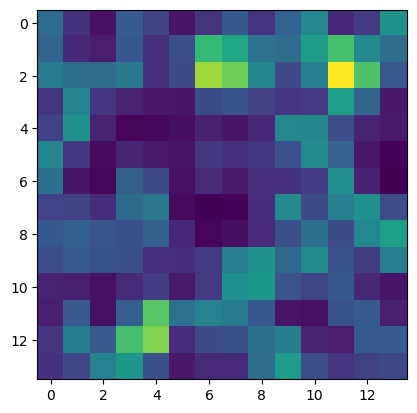

In [13]:
M = signals[0].detach().cpu().numpy()
plt.imshow(M[0,5])